In [86]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import string
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from PIL import Image
from wordcloud import WordCloud


In [2]:
# od.download('https://www.kaggle.com/crowdflower/twitter-airline-sentiment')
# for file in os.listdir(os.path.join(os.curdir, "twitter-airline-sentiment")):
#     shutil.move(os.path.join(os.curdir, "twitter-airline-sentiment/{}".format(file)),os.curdir)
# os.removedirs(os.path.join(os.curdir, "twitter-airline-sentiment"))

In [3]:
tweets = pd.read_csv('Tweets.csv')
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
tweets = tweets[['airline_sentiment','airline_sentiment_confidence','airline','text']]

In [6]:
print(tweets['airline_sentiment'].value_counts())
print('\n')
print(tweets['airline'].value_counts())

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Virgin America'),
  Text(1, 0, 'United'),
  Text(2, 0, 'Southwest'),
  Text(3, 0, 'Delta'),
  Text(4, 0, 'US Airways'),
  Text(5, 0, 'American')])

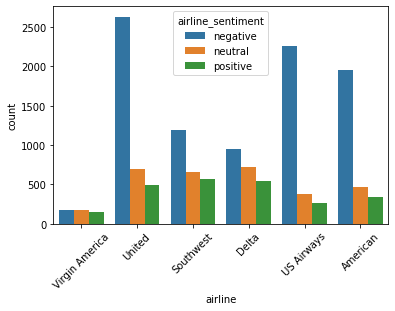

In [7]:
sns.countplot(tweets['airline'],hue=tweets['airline_sentiment'].sort_values())
plt.xticks(rotation=45)

In [8]:
tweets.text

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [9]:
def text_cleaning(text):
    '''
    This function cleans the text in the following ways:
    1. Lowercase all text
    2. Remove strings start with 'http://' or 'https://' or 'www.'
    3. Remove all kinds of brackets
    4. Remove all strings start with '@'
    5. Remove all punctuations
    6. Remove all blank lines
    7. Remove all digit-containing words
    8. Remove all characters that are non-alphanumeric except white space

    for more regular expression check https://www.rexegg.com/regex-quickstart.html
    '''
    
    text = str(text).lower()
    text = re.sub('(http|https)://\S+|www\.\S+', '', text)
    text = re.sub('\(|\)|\[|\]|<|>|\{|\}', '', text)
    text = re.sub('@\S+', '',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[^a-zA-Z\d\s]', '', text)
    # text = re.sub('\[.*\]', '', text)
    # text = re.sub('<.*>', '', text)
    # text = re.sub('\(.*\)', '', text)
    return text

def remove_stopwords(text):
    '''
    This function removes common English stopwords
    '''
    text = ' '.join(word for word in text.split(' ') if word not in stopwords.words('english'))
    return text

def text_lematization(text):
    '''
    This function performs lematization using nltk WordNetLemmatizer
    '''
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    return text
    
tweets.text = tweets.text.apply(text_cleaning)
tweets.text = tweets.text.apply(remove_stopwords)
tweets.text = tweets.text.apply(text_lematization)


In [10]:
tweets.text = tweets.text.apply(lambda t: re.sub('-PRON-','',t))

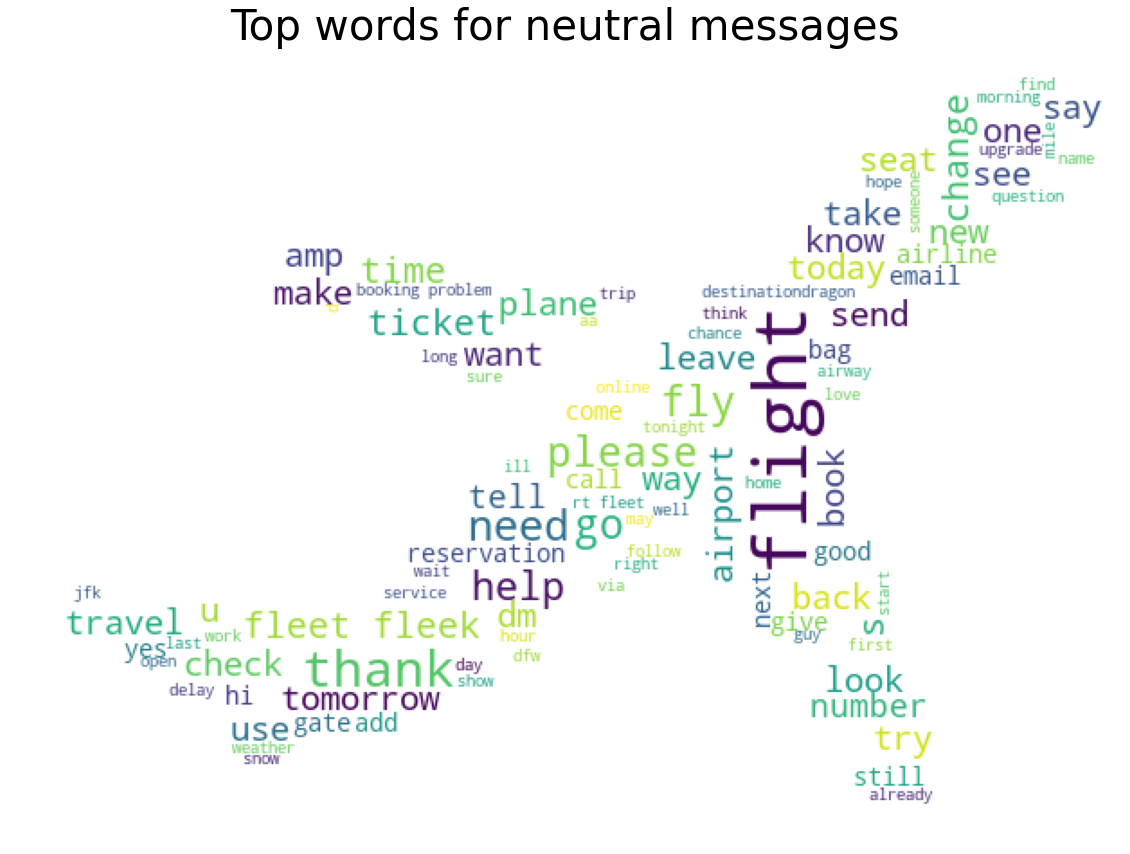

In [11]:
def wordcloud_gen(sentiment):
    wc = WordCloud(background_color='white',max_words=100, mask=np.array(Image.open('plane.jpg')))
    wc.generate(' '.join(doc for doc in tweets[tweets['airline_sentiment']==sentiment]['text']))
    plt.figure(figsize=(20,20))
    plt.title('Top words for '+ sentiment + ' messages', 
          fontdict={'size': 42,  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.imshow(wc)

wordcloud_gen('neutral')

In [84]:
tweets.airline_sentiment = LabelEncoder().fit_transform(tweets.airline_sentiment)

In [74]:
# tfidf = TfidfVectorizer()
# df  = pd.DataFrame(tfidf.fit_transform(tweets.text))

In [91]:
X = tweets.text
y = tweets.airline_sentiment
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
vect = CountVectorizer()
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)


In [92]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)
y_pred_class = nb.predict(x_test_dtm)

In [93]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))


0.7598360655737705
